In [1]:
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial import distance
from torchdiffeq import odeint_adjoint as odeint

Z_DIM = 2
MAX_VAL = 4.0 # The image spans from -4 to +4 units in the x and y directions.

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [2]:
class ODEfunc(nn.Module):
	"""
	Calculates time derivatives.
	torchdiffeq requires this to be a torch.nn.Module.
	"""

	def __init__(self, hidden_dims=(64,64,64)):
		super(ODEfunc, self).__init__()
		# Define network layers.
		dim_list = [Z_DIM] + list(hidden_dims) + [Z_DIM]
		layers = []
		for i in range(len(dim_list)-1):
			layers.append(nn.Linear(dim_list[i]+1, dim_list[i+1]))
		self.layers = nn.ModuleList(layers)


	def get_z_dot(self, t, z):
		"""z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
		z_dot = z
		for l, layer in enumerate(self.layers):
			#print("layer: ", l)
			tz_cat = torch.cat((t.expand(z.shape[0],1), z_dot), dim=1)
			z_dot = layer(tz_cat)
			if l < len(self.layers) - 1:
				z_dot = F.leaky_relu(z_dot)
		return z_dot


	def forward(self, t, states):
		"""
		Calculate the time derivative of z and divergence.
		Parameters
		----------
		t : torch.Tensor
			time
		state : tuple
			Contains two torch.Tensors: z and delta_logpz
		Returns
		-------
		z_dot : torch.Tensor
			Time derivative of z.
		negative_divergence : torch.Tensor
			Time derivative of the log determinant of the Jacobian.
		"""
		z = states[0]
		batchsize = z.shape[0]

		with torch.set_grad_enabled(True):
			z.requires_grad_(True)
			t.requires_grad_(True)

			# Calculate the time derivative of z.
			# This is f(z(t), t; \theta) in Eq. 4.
			z_dot = self.get_z_dot(t, z)

			# Calculate the time derivative of the log determinant of the
			# Jacobian.
			# This is -Tr(\partial z_dot / \partial z(t)) in Eq.s 2-4.
			#
			# Note that this is the brute force, O(D^2), method. This is fine
			# for D=2, but the authors suggest using a Monte-carlo estimate
			# of the trace (Hutchinson's trace estimator, eq. 7) for a linear
			# time estimate in larger dimensions.
			divergence = 0.0
			for i in range(z.shape[1]):
				divergence += \
						torch.autograd.grad( \
							z_dot[:, i].sum(), z, create_graph=True \
						)[0][:, i]

		return z_dot, -divergence.view(batchsize, 1)

In [3]:
class FfjordModel(torch.nn.Module):
	"""Continuous noramlizing flow model."""

	def __init__(self):
		super(FfjordModel, self).__init__()
		self.time_deriv_func = ODEfunc()

	def save_state(self, fn='state.tar'):
		"""Save model state."""
		torch.save(self.state_dict(), fn)

	def load_state(self, fn='state.tar'):
		"""Load model state."""
		self.load_state_dict(torch.load(fn))


	def forward(self, z, delta_logpz=None, integration_times=None, \
		reverse=False):
		"""
		Implementation of Eq. 4.
		We want to integrate both f and the trace term. During training, we
		integrate from t_1 (data distribution) to t_0 (base distibution).
		Parameters
		----------
		z : torch.Tensor
			Samples.
		delta_logpz : torch.Tensor
			Log determininant of the Jacobian.
		integration_times : torch.Tensor
			Which times to evaluate at.
		reverse : bool, optional
			Whether to reverse the integration times.
		Returns
		-------
		z : torch.Tensor
			Updated samples.
		delta_logpz : torch.Tensor
			Updated log determinant term.
		"""
		if delta_logpz is None:
			delta_logpz = torch.zeros(z.shape[0], 1).to(device)
		if integration_times is None:
			integration_times = torch.tensor([0.0, 1.0]).to(z)
		if reverse:
			integration_times = _flip(integration_times, 0)

		# Integrate. This is the call to torchdiffeq.
		state = odeint(
			self.time_deriv_func, # Calculates time derivatives.
			(z, delta_logpz), # Values to update.
			integration_times, # When to evaluate.
			method='dopri5', # Runge-Kutta
			atol=[1e-5, 1e-5], # Error tolerance
			rtol=[1e-5, 1e-5], # Error tolerance
		)

		if len(integration_times) == 2:
			state = tuple(s[1] for s in state)
		z, delta_logpz = state
		return z, delta_logpz

In [4]:
def _flip(x, dim):
	indices = [slice(None)] * x.dim()
	indices[dim] = torch.arange(x.size(dim) - 1, -1, -1, dtype=torch.long, \
			device=x.device)
	return x[tuple(indices)]


def standard_normal_logprob(z):
	"""2d standard normal, sum over the second dimension."""
	return (-np.log(2 * np.pi) - 0.5 * z.pow(2)).sum(1, keepdim=True)


In [5]:
# Define the model.
model = FfjordModel()
model.to(device)

FfjordModel(
  (time_deriv_func): ODEfunc(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Linear(in_features=65, out_features=64, bias=True)
      (2): Linear(in_features=65, out_features=64, bias=True)
      (3): Linear(in_features=65, out_features=2, bias=True)
    )
  )
)

In [6]:
# Dataset
import re
import math
import numpy as np
import torch
import scipy.sparse


from sklearn.preprocessing import StandardScaler


class EBData(object):
    """ Base Class for single cell like trajectory data """

    def __init__(
        self, embedding_name="phate", max_dim=None, use_velocity=True, version=5
    ):
        super().__init__()
        self.val_labels = []
        self.embedding_name = embedding_name
        self.use_velocity = use_velocity
        if version == 5:
            data_file = "./eb_velocity_v5.npz"
        else:
            raise ValueError("Unknown Version number")
        self.load(data_file, max_dim)

    def load(self, data_file, max_dim):
        self.data_dict = np.load(data_file, allow_pickle=True)
        self.labels = self.data_dict["sample_labels"]
        if self.embedding_name not in self.data_dict.keys():
            raise ValueError("Unknown embedding name %s" % self.embedding_name)
        embedding = self.data_dict[self.embedding_name]
        scaler = StandardScaler()
        scaler.fit(embedding)
        self.ncells = embedding.shape[0]
        assert self.labels.shape[0] == self.ncells
        # Scale so that embedding is normally distributed
        self.data = scaler.transform(embedding)

        if self.has_velocity() and self.use_velocity:
            if self.embedding_name == "pcs":
                delta = self.data_dict["pcs_delta"]
            elif self.embedding_name == "phate":
                delta = self.data_dict["delta_embedding"]
            else:
                raise NotImplementedError("rna velocity must use phate")
            assert delta.shape[0] == self.ncells
            # Ignore mean from embedding
            self.velocity = delta / scaler.scale_

        if max_dim is not None and self.data.shape[1] > max_dim:
            print("Warning: Clipping dimensionality to %d" % max_dim)
            self.data = self.data[:, :max_dim]
            if self.has_velocity() and self.use_velocity:
                self.velocity = self.velocity[:, :max_dim]

    def has_velocity(self):
        return True

    def known_base_density(self):
        return False

    def get_data(self):
        return self.data

    def get_times(self):
        return self.labels

    def get_unique_times(self):
        return np.unique(self.labels)

    def get_velocity(self):
        return self.velocity

    def get_shape(self):
        return [self.data.shape[1]]

    def get_ncells(self):
        return self.ncells
    
    def base_density(self):
        def standard_normal_logprob(z):
            logZ = -0.5 * math.log(2 * math.pi)
            return torch.sum(logZ - z.pow(2) / 2, 1, keepdim=True)

        return standard_normal_logprob

    def base_sample(self):
        return torch.randn

    def leaveout_timepoint(self, tp):
        """ Takes a timepoint label to leaveout
        Alters data stored in object to leave out all data associated
        with that timepoint.
        """
        if tp < 0:
            raise RuntimeError("Cannot leaveout negative timepoint %d." % tp)
        mask = self.labels != tp
        print("Leaving out %d samples from sample %d" % (np.sum(~mask), tp))
        self.labels = self.labels[mask]
        self.data = self.data[mask]
        self.velocity = self.velocity[mask]
        self.ncells = np.sum(mask)

    def sample_index(self, n, label_subset):
        arr = np.arange(self.ncells)[self.labels == label_subset]
        return np.random.choice(arr, size=n)


    def plot_density(self):
        import matplotlib.pyplot as plt

        npts = 100
        side = np.linspace(-4, 4, npts)
        xx, yy = np.meshgrid(side, side)
        xx = torch.from_numpy(xx).type(torch.float32)
        yy = torch.from_numpy(yy).type(torch.float32)
        z_grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], 1)
        logp_grid = data.base_density()(z_grid)
        plt.pcolormesh(xx, yy, np.exp(logp_grid.numpy()).reshape(npts, npts))
        plt.show()

    def plot_data(self):
        import scprep
        import matplotlib.pyplot as plt

        nbase = 5000
        all_data = np.concatenate(
            [self.get_data(), self.base_sample()(nbase, self.get_shape()[0]).numpy()],
            axis=0,
        )
        lbs = np.concatenate([self.get_times(), np.repeat(["Base"], nbase)])
        if all_data.shape[1] == 2:
            scprep.plot.scatter2d(all_data, c=lbs)
        else:
            fig, axes = plt.subplots(2, all_data.shape[1] // 2)
            axes = axes.flatten()
            for i in range(all_data.shape[1] - 1):
                scprep.plot.scatter2d(
                    all_data[:, i : i + 2],
                    c=lbs,
                    ax=axes[i],
                    xlabel="PC %d" % (i + 1),
                    ylabel="PC %d" % (i + 2),
                )
        plt.show()

    def plot_velocity(self):
        import matplotlib.pyplot as plt

        idx = np.random.randint(self.get_ncells(), size=200)
        data = self.get_data()[idx]
        velocity = self.velocity[idx]
        plt.quiver(data[:, 0], data[:, 1], velocity[:, 0], velocity[:, 1])
        plt.show()

    def plot_paths(self):
        paths = self.get_paths()
        paths = paths[:1000]
        import matplotlib.pyplot as plt

        for path in paths:
            plt.plot(path[:, 0], path[:, 1])
        plt.show()

    def factory(name, md):
        if name == "SCURVE":
            return SklearnData("scurve")

In [7]:
ebdata = EBData()

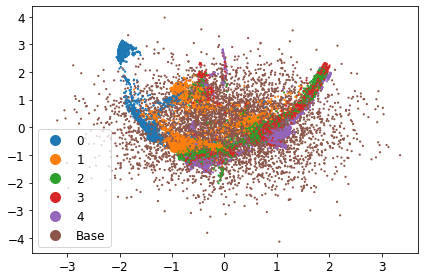

In [8]:
ebdata.plot_data()

In [9]:
time_scale = 0.5
timepoints = ebdata.get_unique_times()
int_tps = (np.arange(max(timepoints) + 1) + 1.0) * time_scale

In [10]:
print(timepoints)
print(int_tps)

[0 1 2 3 4]
[0.5 1.  1.5 2.  2.5]


In [11]:
batch_size = 1000
dir_reg_coeff = 0.0001
density_reg_coeff = 0.0001
leaveout_timepoint = 2

In [12]:




def compute_loss(model, full_data):
    # Backward pass accumulating losses, previous state and deltas
    deltas = []
    zs = []
    z = None
    interp_loss = 0.0
    for i, (itp, tp) in enumerate(zip(int_tps[::-1], timepoints[::-1])):
        integration_times = torch.tensor([itp - time_scale, itp])
        integration_times = integration_times.type(torch.float32).to(device)

        # load data and add noise
        idx = ebdata.sample_index(batch_size, tp)
        x = ebdata.get_data()[idx]
#         if args.training_noise > 0.0:
#             x += np.random.randn(*x.shape) * args.training_noise
        x = torch.from_numpy(x).type(torch.float32).to(device)

        if i > 0:
            x = torch.cat((z, x))
            zs.append(z)
        zero = torch.zeros(x.shape[0], 1).to(x)

        # transform to previous timepoint
        z, delta_logp = model(x, zero, integration_times=integration_times)
        deltas.append(delta_logp)

    logpz = ebdata.base_density()(z)

    # build growth rates
#     if args.use_growth:
#         growthrates = [torch.ones_like(logpz)]
#         for z_state, tp in zip(zs[::-1], args.timepoints[:-1]):
#             # Full state includes time parameter to growth_model
#             time_state = tp * torch.ones(z_state.shape[0], 1).to(z_state)
#             full_state = torch.cat([z_state, time_state], 1)
#             growthrates.append(growth_model(full_state))

    # Accumulate losses
    losses = []
    logps = [logpz]
    for i, delta_logp in enumerate(deltas[::-1]):
        logpx = logps[-1] - delta_logp
#         if args.use_growth:
#             logpx += torch.log(torch.clamp(growthrates[i], 1e-4, 1e4))
        logps.append(logpx[: -batch_size])
        losses.append(-torch.mean(logpx[-batch_size :]))
    losses = torch.stack(losses)
    weights = torch.ones_like(losses).to(logpx)
    if leaveout_timepoint >= 0:
        weights[leaveout_timepoint] = 0
    losses = torch.mean(losses * weights)
    
    '''Direction regularization'''
    if dir_reg_coeff > 0:
        similarity_loss = 0
        for i, (itp, tp) in enumerate(zip(int_tps, timepoints)):
            itp = torch.tensor(itp).type(torch.float32).to(device)
            idx = ebdata.sample_index(batch_size, tp)
            x = ebdata.get_data()[idx]
            v = ebdata.get_velocity()[idx]
            x = torch.from_numpy(x).type(torch.float32).to(device)
            v = torch.from_numpy(v).type(torch.float32).to(device)
            x += torch.randn_like(x) * 0.1 #adding noise
            direction = -model.time_deriv_func.get_z_dot(itp, x)
            similarity_loss -= torch.mean(F.cosine_similarity(direction, v))
        losses += similarity_loss * dir_reg_coeff
        
    '''Density regularization'''
    if density_reg_coeff > 0:
        density_loss = 0
        tp_z_map = dict(zip(timepoints[:-1], zs[::-1]))
        if leaveout_timepoint not in tp_z_map:
            idx = ebdata.sample_index(batch_size, tp)
            x = ebdata.get_data()[idx]
    #         if args.training_noise > 0.0:
    #             x += np.random.randn(*x.shape) * args.training_noise
            x = torch.from_numpy(x).type(torch.float32).to(device)
            t = 1 #np.random.rand()
            int_t = torch.tensor([itp - t * time_scale, itp])
            int_t = int_t.type(torch.float32).to(device)
            samples_05, _ = model(x, integration_times=int_t)
        else:
            # If leaving out a timepoint then regularize there
            samples_05 = tp_z_map[leaveout_timepoint]

        cdist = distance.cdist(samples_05.detach(), full_data.detach(), 'euclidean') #was breaking on Pytorch, hence using scipy
        values, indices = torch.topk(torch.Tensor(cdist), 5, dim=1, largest=False, sorted=False)
        
        hinge_value = 0.1
        values -= hinge_value
        values[values < 0] = 0.0
#         where_are_NaNs = np.isnan(values.detach())
#         values[where_are_NaNs] = 0.0
        density_loss = torch.mean(values)
        losses += (density_loss * density_reg_coeff)
    
    return losses

In [13]:
# Train.
full_data = (torch.from_numpy(ebdata.get_data()[ebdata.get_times() != leaveout_timepoint]).type(torch.float32).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.train()
for batch in range(2500):
    # Zero gradients.
    optimizer.zero_grad()

    # Sample from the image distribution.
    loss = compute_loss(model, full_data)
    print(batch, loss)

    # Take an optimization step.
    loss.backward()
    optimizer.step()

0 tensor(2.9468, grad_fn=<AddBackward0>)
1 tensor(2.9094, grad_fn=<AddBackward0>)
2 tensor(2.9026, grad_fn=<AddBackward0>)
3 tensor(2.8860, grad_fn=<AddBackward0>)
4 tensor(2.8924, grad_fn=<AddBackward0>)
5 tensor(2.8835, grad_fn=<AddBackward0>)
6 tensor(2.8731, grad_fn=<AddBackward0>)
7 tensor(2.8346, grad_fn=<AddBackward0>)
8 tensor(2.8330, grad_fn=<AddBackward0>)
9 tensor(2.8533, grad_fn=<AddBackward0>)
10 tensor(2.8128, grad_fn=<AddBackward0>)
11 tensor(2.8171, grad_fn=<AddBackward0>)
12 tensor(2.7762, grad_fn=<AddBackward0>)
13 tensor(2.7564, grad_fn=<AddBackward0>)
14 tensor(2.7541, grad_fn=<AddBackward0>)
15 tensor(2.7422, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [ ]:
# Visualize Output

def get_transforms(model, integration_times):

    def sample_fn(z, logpz=None):
        int_list = [
            torch.tensor([it - time_scale, it]).type(torch.float32).to(device)
            for it in integration_times
        ]
        if logpz is not None:
            # TODO this works right?
            for it in int_list:
                z, logpz = model(z, logpz, integration_times=it, reverse=True)
            return z, logpz
        else:
            for it in int_list:
                z = model(z, integration_times=it, reverse=True)
            return z[0]

    def density_fn(x, logpx=None):
        int_list = [
            torch.tensor([it - time_scale, it]).type(torch.float32).to(device)
            for it in integration_times[::-1]
        ]
        if logpx is not None:
            for it in int_list:
                x, logpx = model(x, logpx, integration_times=it, reverse=False)
            return x, logpx
        else:
            for it in int_list:
                x = model(x, integration_times=it, reverse=False)
            return x[0]

    return sample_fn, density_fn

In [ ]:
# import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import torch

LOW = -4
HIGH = 4


def plt_potential_func(potential, ax, npts=100, title="$p(x)$"):
    """
    Args:
        potential: computes U(z_k) given z_k
    """
    xside = np.linspace(LOW, HIGH, npts)
    yside = np.linspace(LOW, HIGH, npts)
    xx, yy = np.meshgrid(xside, yside)
    z = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    z = torch.Tensor(z)
    u = potential(z).cpu().numpy()
    p = np.exp(-u).reshape(npts, npts)

    plt.pcolormesh(xx, yy, p)
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)


def plt_flow(prior_logdensity, transform, ax, npts=100, title="$q(x)$ Generated", device="cpu"):
    """
    Args:
        transform: computes z_k and log(q_k) given z_0
    """
    side = np.linspace(LOW, HIGH, npts)
    xx, yy = np.meshgrid(side, side)
    z = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    z = torch.tensor(z, requires_grad=True).type(torch.float32).to(device)
    logqz = prior_logdensity(z)
    z, logqz = transform(z, logqz)
    logqz = torch.sum(logqz, dim=1)[:, None]

    xx = z[:, 0].cpu().detach().numpy().reshape(npts, npts)
    yy = z[:, 1].cpu().detach().numpy().reshape(npts, npts)
    qz = np.exp(logqz.cpu().detach().numpy()).reshape(npts, npts)

    plt.pcolormesh(xx, yy, qz)
    ax.set_xlim(LOW, HIGH)
    ax.set_ylim(LOW, HIGH)
    cmap = matplotlib.cm.get_cmap(None)
    ax.set_facecolor(cmap(0.))
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)


def plt_flow_density(prior_logdensity, inverse_transform, ax, npts=100, memory=100, title="$q(x)$ True", device="cpu"):
    side = np.linspace(LOW, HIGH, npts)
    xx, yy = np.meshgrid(side, side)
    x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    x = torch.from_numpy(x).type(torch.float32).to(device)
    zeros = torch.zeros(x.shape[0], 1).to(x)

    z, delta_logp = [], []
    inds = torch.arange(0, x.shape[0]).to(torch.int64)
    for ii in torch.split(inds, int(memory**2)):
        z_, delta_logp_ = inverse_transform(x[ii], zeros[ii])
        z.append(z_)
        delta_logp.append(delta_logp_)
    z = torch.cat(z, 0)
    delta_logp = torch.cat(delta_logp, 0)

    logpz = prior_logdensity(z)
    logpx = logpz - delta_logp

    px = np.exp(logpx.detach().numpy()).reshape(npts, npts)

    ax.imshow(px)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)


def plt_flow_samples(prior_sample, transform, ax, npts=100, memory=100, title="$x ~ q(x)$ Generated", device="cpu"):
#     z = prior_sample(npts * npts, 2).type(torch.float32).to(device)
#     zk = []
#     inds = torch.arange(0, z.shape[0]).to(torch.int64)
#     for ii in torch.split(inds, int(memory**2)):
#         zk.append(transform(z[ii]))
#     zk = torch.cat(zk[0], 0).cpu().numpy()

    z = transform(prior_sample(npts * npts, 2).type(torch.float32).to(device))
    zk = z.detach().numpy()
    ax.hist2d(zk[:, 0], zk[:, 1], range=[[LOW, HIGH], [LOW, HIGH]], bins=npts)
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)


def plt_samples(samples, ax, npts=100, title="$x ~ p(x)$ True"):
    ax.hist2d(samples[:, 0], samples[:, 1], range=[[LOW, HIGH], [LOW, HIGH]], bins=npts)
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)

def visualize_growth(growth_model, full_data, labels, npts=200, memory=100, device='cpu'):
    with torch.no_grad():
        fig, ax = plt.subplots(1,1)
        side = np.linspace(LOW, HIGH, npts)
        xx, yy = np.meshgrid(side, side)
        x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
        x = torch.from_numpy(x).type(torch.float32).to(device)
        output_growth = growth_model(x).cpu().numpy()
        output_growth = np.reshape(output_growth, (npts, npts))
        im = ax.imshow(output_growth, cmap = 'bwr')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        fig.colorbar(im, ax=ax)
        ax.set_title('Growth Rate')
        
        # rescale full data to image coordinates
        full_data = full_data * npts / 8 + npts / 2
        #ax.scatter(full_data[:,0], full_data[:,1], c=labels / 5, cmap='Spectral', s=10,alpha=0.5)


def visualize_transform(
    potential_or_samples, prior_sample, prior_density, transform=None, inverse_transform=None, samples=True, npts=100,
    memory=100, device="cpu"
):
    """Produces visualization for the model density and samples from the model."""
    plt.clf()
    ax = plt.subplot(1, 3, 1, aspect="equal")
    if samples:
        plt_samples(potential_or_samples, ax, npts=npts)
    else:
        plt_potential_func(potential_or_samples, ax, npts=npts)

    ax = plt.subplot(1, 3, 2, aspect="equal")
    if inverse_transform is None:
        plt_flow(prior_density, transform, ax, npts=npts, device=device)
    else:
        plt_flow_density(prior_density, inverse_transform, ax, npts=npts, memory=memory, device=device)

    ax = plt.subplot(1, 3, 3, aspect="equal")
    if transform is not None:
#         plt_flow_samples(prior_sample, transform, ax, npts=npts, memory=memory, device=device)
        plt_flow(prior_density, transform, ax, npts=npts, device=device)

In [ ]:
def visualize(device, model, itr):
    model.eval()
    for i, tp in enumerate(timepoints):
        idx = ebdata.sample_index(1000, tp)
        p_samples = ebdata.get_data()[idx]
        sample_fn, density_fn = get_transforms(
            model, int_tps[: i + 1]
        )
        plt.figure(figsize=(9, 3))
        visualize_transform(
            p_samples,
            ebdata.base_sample(),
            ebdata.base_density(),
            transform=sample_fn,
            inverse_transform=density_fn, #density_fn
            samples=True,
            npts=100,
            device=device,
        )
#         fig_filename = os.path.join(
#             args.save, "figs", "{:04d}_{:01d}.jpg".format(itr, i)
#         )
#         utils.makedirs(os.path.dirname(fig_filename))
#         plt.savefig(fig_filename)
        plt.show()

In [ ]:
visualize(device, model, 2500)

In [ ]:
''' Code for testing using EMD '''

import numpy as np
import ot as pot  # Python Optimal Transport package
import scipy.sparse
from sklearn.metrics.pairwise import pairwise_distances


def earth_mover_distance(
    p,
    q,
    eigenvals=None,
    weights1=None,
    weights2=None,
    return_matrix=False,
    metric="sqeuclidean",
):
    """
    Returns the earth mover's distance between two point clouds
    Parameters
    ----------
    cloud1 : 2-D array
        First point cloud
    cloud2 : 2-D array
        Second point cloud
    Returns
    -------
    distance : float
        The distance between the two point clouds
    """
    p = p.toarray() if scipy.sparse.isspmatrix(p) else p
    q = q.toarray() if scipy.sparse.isspmatrix(q) else q
    if eigenvals is not None:
        p = p.dot(eigenvals)
        q = q.dot(eigenvals)
    if weights1 is None:
        p_weights = np.ones(len(p)) / len(p)
    else:
        weights1 = weights1.astype("float64")
        p_weights = weights1 / weights1.sum()

    if weights2 is None:
        q_weights = np.ones(len(q)) / len(q)
    else:
        weights2 = weights2.astype("float64")
        q_weights = weights2 / weights2.sum()

    pairwise_dist = np.ascontiguousarray(
        pairwise_distances(p, Y=q, metric=metric, n_jobs=-1)
    )

    result = pot.emd2(
        p_weights, q_weights, pairwise_dist, numItermax=1e7, return_matrix=return_matrix
    )
    if return_matrix:
        square_emd, log_dict = result
        return np.sqrt(square_emd), log_dict
    else:
        return np.sqrt(result)

def test_model(device, model, n=10000, timepoint=None):

    z_samples = ebdata.base_sample()(n, ebdata.get_shape()[0]).to(device)
    # Forward pass through the model / growth model
    with torch.no_grad():
        int_list = [
            torch.tensor([it - time_scale, it]).type(torch.float32).to(device)
            for it in int_tps[: timepoint + 1]
        ]

        logpz = ebdata.base_density()(z_samples)
        z = z_samples
        for it in int_list:
            z, logpz = model(z, logpz, integration_times=it, reverse=True)
        z = z.cpu().numpy()
        logpz = logpz.cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], alpha=0.5)
        
        original_data = ebdata.get_data()[ebdata.get_times() == timepoint]
        idx = np.random.randint(original_data.shape[0], size=n)
        samples = original_data[idx, :]
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)

        plt.show()

        pz = np.exp(logpz)
        pz = pz / np.sum(pz)
        print(pz)

        print(
            earth_mover_distance(
                original_data, samples + np.random.randn(*samples.shape) * 0.1
            )
        )

        print(earth_mover_distance(z, original_data))
        print(earth_mover_distance(z, samples))
        

In [ ]:
test_model(device, model, n=2000, timepoint=leaveout_timepoint)